# ASSUMPTIONS:

I assumed that Airbnb properties have an occupancy rate of 75%

The following report from NYC government projects average occupancy to be ~80%. So our assumption is fair.
https://www1.nyc.gov/assets/planning/download/pdf/plans-studies/m1-hotel-text/nyc-hotel-market-analysis.pdf

Revenue from extra guests are also considered and it is assumed that 30% of the allowable guests will be using the property.

Median values of revenues and property prices are considered to avoid the outliers effect in the analysis.

It is assumed that the company will make investment in 2020. Hence the property values are predicted accordingly using Time series ARIMA and the revenues are also adjusted for growth (growth from 2017 to 2020) to calculate the ROI.

Any operating costs like maintenance etc. are assumed to be recovered from the customer though service fee tax etc. So all the revenues are profits and are directly used in ROI calculation.

Properties with high ROI (%) and low Payback_period (in years) are considered as more favourable. 

The investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for)

The time value of money discount rate is 0% (i.e. $1 today is worth the same 100 years from now). So that the payback_period is calculated at a flat annual revenue.

All properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property within that same locale)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

airbnb = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\CapitalOne\Final\listings.gz", low_memory = False)
airbnb.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7949480,https://www.airbnb.com/rooms/7949480,20170502132028,2017-05-03,City Island Sanctuary relaxing BR & Bath w Par...,Come relax on City Island in our quiet guest r...,"On parle français et anglais, (lire Français c...",Come relax on City Island in our quiet guest r...,none,City Island is a unique sanctuary in New York ...,...,10.0,f,NaN,NaN,f,moderate,t,t,1,1.59
1,16042478,https://www.airbnb.com/rooms/16042478,20170502132028,2017-05-04,WATERFRONT STUDIO APARTMENT,My place is close to Sea Shore. You’ll love my...,(URL HIDDEN),My place is close to Sea Shore. You’ll love my...,none,(URL HIDDEN),...,NaN,f,NaN,NaN,t,flexible,f,f,1,NaN


We have a total of 95 columns out of which id,zipcode,city,host_acceptance_rate,price,cleaning fee,bedrooms,square feet,latitude,longitude,reviews per month,availability_30,availability_365 might be useful for our analysis.We shall first take a look at the data and decide on further steps

# Summary statistics

In [2]:
airbnb_1 = airbnb[['host_id','id', 'zipcode', 'city', 'host_acceptance_rate','host_response_rate', 'bedrooms','price', 'cleaning_fee','extra_people','guests_included','square_feet','latitude','longitude',
                   'reviews_per_month','availability_30','availability_365','neighbourhood_group_cleansed','property_type','room_type']]
airbnb_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40753 entries, 0 to 40752
Data columns (total 20 columns):
host_id                         40753 non-null int64
id                              40753 non-null int64
zipcode                         40142 non-null object
city                            40709 non-null object
host_acceptance_rate            0 non-null float64
host_response_rate              27611 non-null object
bedrooms                        40684 non-null float64
price                           40753 non-null object
cleaning_fee                    28061 non-null object
extra_people                    40753 non-null object
guests_included                 40753 non-null int64
square_feet                     567 non-null float64
latitude                        40753 non-null float64
longitude                       40753 non-null float64
reviews_per_month               31454 non-null float64
availability_30                 40753 non-null int64
availability_365               

In [3]:
airbnb_1.describe()

,host_id,id,host_acceptance_rate,bedrooms,guests_included,square_feet,latitude,longitude,reviews_per_month,availability_30,availability_365
count,4.075300e+04,4.075300e+04,0.0,40684.000000,40753.000000,567.000000,40753.000000,40753.000000,31454.000000,40753.000000,40753.000000
mean,3.059031e+07,9.912016e+06,NaN,1.148535,1.456016,718.178131,40.730776,-73.955952,1.312114,7.344220,134.081614
std,3.267980e+07,5.582254e+06,NaN,0.698466,1.046750,747.405894,0.053690,0.041214,1.757380,10.055596,137.809093
min,7.200000e+01,2.515000e+03,NaN,0.000000,1.000000,0.000000,40.499794,-74.240843,0.010000,0.000000,0.000000
25%,4.857042e+06,4.995083e+06,NaN,1.000000,1.000000,250.000000,40.692356,-73.983946,0.250000,0.000000,0.000000
50%,1.805129e+07,1.001931e+07,NaN,1.000000,1.000000,650.000000,40.724119,-73.957210,0.750000,2.000000,84.000000
75%,4.664988e+07,1.496799e+07,NaN,1.000000,2.000000,900.000000,40.764489,-73.940474,1.910000,12.000000,277.000000
max,1.284849e+08,1.851999e+07,NaN,10.000000,16.000000,10118.000000,40.912164,-73.711750,125.920000,30.000000,365.000000


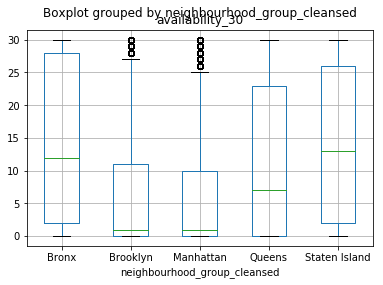

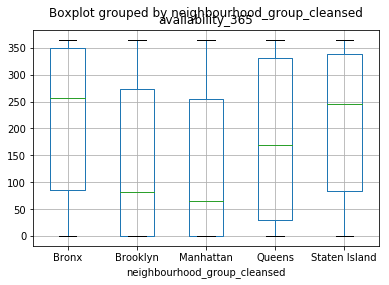

In [4]:
airbnb_1.boxplot(by='neighbourhood_group_cleansed',column=airbnb_1.columns[15])
airbnb_1.boxplot(by='neighbourhood_group_cleansed',column=airbnb_1.columns[16])
plt.show()

In [5]:
airbnb_1.head()
#airbnb_1[airbnb_1['bedrooms'].notnum()]
# N/A|NA|na|n/a

,host_id,id,zipcode,city,host_acceptance_rate,host_response_rate,bedrooms,price,cleaning_fee,extra_people,guests_included,square_feet,latitude,longitude,reviews_per_month,availability_30,availability_365,neighbourhood_group_cleansed,property_type,room_type
0,119445,7949480,10464,Bronx,NaN,100%,1.0,$99.00,NaN,$20.00,1,NaN,40.852054,-73.788680,1.59,24,170,Bronx,House,Private room
1,9117975,16042478,10464,Bronx,NaN,0%,1.0,$200.00,NaN,$0.00,1,NaN,40.853491,-73.788607,NaN,30,180,Bronx,Apartment,Private room
2,9815788,1886820,10464,Bronx,NaN,NaN,3.0,$300.00,$100.00,$25.00,4,NaN,40.841144,-73.783052,NaN,30,365,Bronx,House,Entire home/apt
3,13886510,6627449,10464,City Island,NaN,100%,1.0,$125.00,$75.00,$0.00,1,NaN,40.849775,-73.786609,0.54,8,335,Bronx,Apartment,Entire home/apt
4,28811542,5557381,10464,Bronx,NaN,100%,1.0,$69.00,$17.00,$15.00,2,NaN,40.850024,-73.789328,3.63,17,352,Bronx,House,Private room


price, cleaning_fee and  extra_people are taken as in object format so we need to clean them before the analysis.
Price, extra_people and Cleaning_fee have '$' and we need to remove them.

In [6]:
import warnings
warnings.filterwarnings('ignore')
# Cleaning the data- Before imputing the missing values we need to remove the $ signs
airbnb_1['price'] = pd.to_numeric(airbnb_1['price'].astype(str).str.replace(",","").str.strip("$"))
airbnb_1['extra_people'] = pd.to_numeric(airbnb_1['extra_people'].astype(str).str.replace(",","").str.strip("$"))
airbnb_1['cleaning_fee'] = pd.to_numeric(airbnb_1['cleaning_fee'].astype(str).str.replace("nan","").str.strip("$"))

In [7]:
airbnb_1.describe()

,host_id,id,host_acceptance_rate,bedrooms,price,cleaning_fee,extra_people,guests_included,square_feet,latitude,longitude,reviews_per_month,availability_30,availability_365
count,4.075300e+04,4.075300e+04,0.0,40684.000000,40753.000000,28061.000000,40753.000000,40753.000000,567.000000,40753.000000,40753.000000,31454.000000,40753.000000,40753.000000
mean,3.059031e+07,9.912016e+06,NaN,1.148535,145.286359,59.899184,13.166000,1.456016,718.178131,40.730776,-73.955952,1.312114,7.344220,134.081614
std,3.267980e+07,5.582254e+06,NaN,0.698466,209.946665,44.983672,21.907671,1.046750,747.405894,0.053690,0.041214,1.757380,10.055596,137.809093
min,7.200000e+01,2.515000e+03,NaN,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,40.499794,-74.240843,0.010000,0.000000,0.000000
25%,4.857042e+06,4.995083e+06,NaN,1.000000,70.000000,25.000000,0.000000,1.000000,250.000000,40.692356,-73.983946,0.250000,0.000000,0.000000
50%,1.805129e+07,1.001931e+07,NaN,1.000000,100.000000,50.000000,0.000000,1.000000,650.000000,40.724119,-73.957210,0.750000,2.000000,84.000000
75%,4.664988e+07,1.496799e+07,NaN,1.000000,170.000000,80.000000,20.000000,2.000000,900.000000,40.764489,-73.940474,1.910000,12.000000,277.000000
max,1.284849e+08,1.851999e+07,NaN,10.000000,10000.000000,600.000000,300.000000,16.000000,10118.000000,40.912164,-73.711750,125.920000,30.000000,365.000000


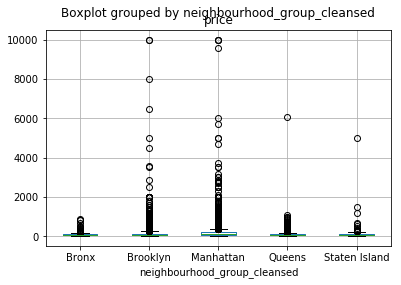

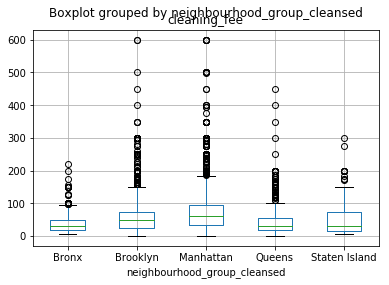

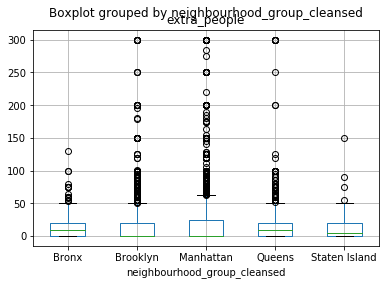

In [8]:
airbnb_1.boxplot(by='neighbourhood_group_cleansed',column=airbnb_1.columns[7])
airbnb_1.boxplot(by='neighbourhood_group_cleansed',column=airbnb_1.columns[8])
airbnb_1.boxplot(by='neighbourhood_group_cleansed',column=airbnb_1.columns[9])
plt.show()

As we can see above there are lot of outliers in the price information
Mean and median values are far apart as we can see from the summary table
So its better to consider Median values of metrics than the Mean values.

In [9]:
airbnb_1.city.value_counts()
# we can see there is repetition of brooklyn twice this might be because of the extra spaces etc.
#  So shall TRIM all the object type columns in the dataframe

New York                          19499
Brooklyn                          15932
Queens                             2654
Bronx                               586
Brooklyn                            479
Staten Island                       237
Astoria                             179
Long Island City                    101
Flushing                             62
Ridgewood                            42
brooklyn                             41
Woodside                             34
Astoria                              32
Bronx                                28
New York                             26
Elmhurst                             21
Jamaica                              21
Jackson Heights                      19
Queens                               16
Flushing                             15
Corona                               15
Ridgewood                            14
Rego Park                            13
Forest Hills                         13
Bushwick                             13


# Trimming the location names to avoid repititions

In [10]:
def remove_whitespace(x):
    try:
        # remove spaces inside and outside of string
        x = "".join(x.split())
    except:
        pass
    return x

# Apply remove_whitespace to column only
#df.orderId = df.orderId.apply(remove_whitespace)
#print(df)


# Apply to remove_whitespace to entire Dataframe
airbnb_1 = airbnb_1.applymap(remove_whitespace)

airbnb_1.city.value_counts()

NewYork                               19527
Brooklyn                              16415
Queens                                 2670
Bronx                                   614
StatenIsland                            248
Astoria                                 211
LongIslandCity                          103
Flushing                                 77
Ridgewood                                56
brooklyn                                 50
Woodside                                 41
Jamaica                                  32
Elmhurst                                 32
JacksonHeights                           23
Corona                                   19
Sunnyside                                19
Bushwick                                 16
EastElmhurst                             14
ForestHills                              13
Arverne                                  13
RegoPark                                 13
LongIslandcity                           12
flushing                        

All repetition of values are removed now. However we have another column with clean neighbourhood names ('neighbourhood_group_cleansed'). So we will use this column for our analysis.

In [11]:
airbnb_1.neighbourhood_group_cleansed.value_counts()

Manhattan       19212
Brooklyn        16810
Queens           3821
Bronx             649
StatenIsland      261
Name: neighbourhood_group_cleansed, dtype: int64

# Data Quality check

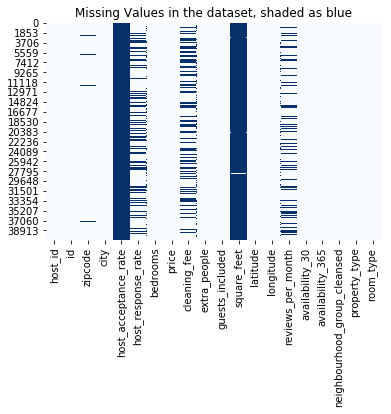

(40753, 20)

In [12]:
# looking at the null values in the data
plt.title("Missing Values in the dataset, shaded as blue")
airbnb_1.isnull().sum()
sns.heatmap(airbnb_1.isnull(), cbar=False, cmap = "Blues")
plt.show()
airbnb_1.shape

There are very few missing values in the id,city,bedrooms,price,latitude,longitude,availability_30,availability_365 columns.
This would make our work easier. We do not have the 'square_feet' & 'host_acceptance_rate' values in the data provided, so we can remove that from our analysis.

As we are concentrating only on the properties with 2 bedrooms we will filter such records from the data.

In [13]:
#Selecting only the 2 bedroom listings
airbnb_2bhk = airbnb_1[airbnb_1['bedrooms'] == 2]
print(airbnb_2bhk.head())
print(airbnb_2bhk.shape)

      host_id        id zipcode     city  host_acceptance_rate  \
12   49293611   9513511   10462    Bronx                   NaN   
23   23732730   5046189   10469    Bronx                   NaN   
33    7809661   4357134   11102  NewYork                   NaN   
36  104034426  16027061   11102   Queens                   NaN   
38    1448564  11301089   11105  Astoria                   NaN   

   host_response_rate  bedrooms  price  cleaning_fee  extra_people  \
12                NaN       2.0  130.0           NaN           0.0   
23               100%       2.0  150.0          75.0          25.0   
33                NaN       2.0  200.0           NaN           0.0   
36                NaN       2.0  250.0           NaN           0.0   
38                95%       2.0   79.0         400.0          25.0   

    guests_included  square_feet   latitude  longitude  reviews_per_month  \
12                3          NaN  40.857532 -73.866055               0.40   
23                2         

# Selecting the required columns

In [14]:
airbnb_data = airbnb_2bhk[['zipcode', 'bedrooms', 'price', 'cleaning_fee','latitude','longitude','neighbourhood_group_cleansed','extra_people','guests_included']]
print(airbnb_data.head())

   zipcode  bedrooms  price  cleaning_fee   latitude  longitude  \
12   10462       2.0  130.0           NaN  40.857532 -73.866055   
23   10469       2.0  150.0          75.0  40.870541 -73.846807   
33   11102       2.0  200.0           NaN  40.771715 -73.917688   
36   11102       2.0  250.0           NaN  40.779373 -73.915532   
38   11105       2.0   79.0         400.0  40.780802 -73.910246   

   neighbourhood_group_cleansed  extra_people  guests_included  
12                        Bronx           0.0                3  
23                        Bronx          25.0                2  
33                       Queens           0.0                1  
36                       Queens           0.0                1  
38                       Queens          25.0                1  


# Data Cleaning
There are few hyphens in zipcode and we need to remove the hyphen and later part

In [15]:
import warnings
warnings.filterwarnings('ignore')

# There is zipcode having hyphen in between,So we should remove the hyphen and values after hyphen
# Found while imputing the missing zipcodes in the error message
airbnb_data['zipcode'] = airbnb_data['zipcode'].astype(str).str.split('-').str[0]
airbnb_data[['zipcode','price','cleaning_fee']] = airbnb_data[['zipcode','price','cleaning_fee']].astype(float)

airbnb_data.isnull().sum()
# we still have nulls in the data in the 'zipcode' and 'cleaning_fee' columns

zipcode                          62
bedrooms                          0
price                             0
cleaning_fee                    966
latitude                          0
longitude                         0
neighbourhood_group_cleansed      0
extra_people                      0
guests_included                   0
dtype: int64

# Imputing Missing Values

We have 62 zipcodes missing in our dataset and we can use K means to impute these missing Zipcodes.I am using Latitude, Longitude and zipcodes for the KNN and Imputing the zipcode by using K=1.By this our KNN looks for the nearest latitude and longitude for the missing zipcodes and since we used K=1,it imputes the missing zipcode with the zipcode of geographically nearest listing

In [16]:
%%capture
from fancyimpute import KNN
warnings.filterwarnings('ignore')
# you have to uninstall numpy and reinstall numpy
# you have to install tensorflow for fancyimpute to work

missing_zipcode = KNN(k=1).fit_transform(airbnb_data[['latitude','longitude','zipcode']])
airbnb_data['zipcode'] = missing_zipcode[:,-1]
missing_cleaning_fee = KNN(k=5).fit_transform(airbnb_data[['zipcode','cleaning_fee']])
airbnb_data['cleaning_fee'] = missing_cleaning_fee[:,-1].astype(int)

In [17]:
warnings.filterwarnings('ignore')
# Now we have the cleaned data set with no missing values
import math
airbnb_data['zipcode'].astype(int)
airbnb_data.zipcode = [math.trunc(x) for x in airbnb_data.zipcode]
print(airbnb_data.isna().sum())
airbnb_data.info()

zipcode                         0
bedrooms                        0
price                           0
cleaning_fee                    0
latitude                        0
longitude                       0
neighbourhood_group_cleansed    0
extra_people                    0
guests_included                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4894 entries, 12 to 40752
Data columns (total 9 columns):
zipcode                         4894 non-null int64
bedrooms                        4894 non-null float64
price                           4894 non-null float64
cleaning_fee                    4894 non-null int32
latitude                        4894 non-null float64
longitude                       4894 non-null float64
neighbourhood_group_cleansed    4894 non-null object
extra_people                    4894 non-null float64
guests_included                 4894 non-null int64
dtypes: float64(5), int32(1), int64(2), object(1)
memory usage: 363.2+ KB


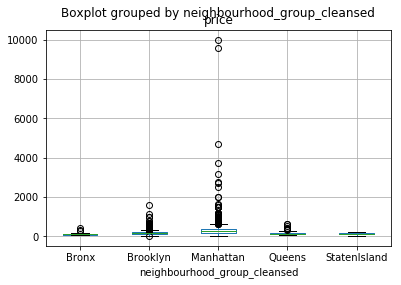

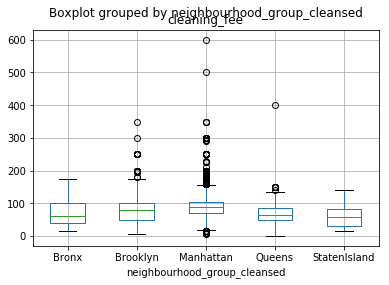

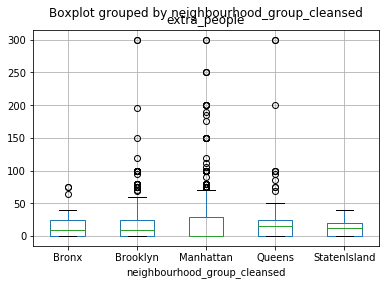

In [18]:
airbnb_data.boxplot(by='neighbourhood_group_cleansed',column=airbnb_data.columns[2])
airbnb_data.boxplot(by='neighbourhood_group_cleansed',column=airbnb_data.columns[3])
airbnb_data.boxplot(by='neighbourhood_group_cleansed',column=airbnb_data.columns[7])
plt.show()

In [19]:
airbnb_data.head()

,zipcode,bedrooms,price,cleaning_fee,latitude,longitude,neighbourhood_group_cleansed,extra_people,guests_included
12,10462,2.0,130.0,124,40.857532,-73.866055,Bronx,0.0,3
23,10469,2.0,150.0,75,40.870541,-73.846807,Bronx,25.0,2
33,11102,2.0,200.0,48,40.771715,-73.917688,Queens,0.0,1
36,11102,2.0,250.0,48,40.779373,-73.915532,Queens,0.0,1
38,11105,2.0,79.0,400,40.780802,-73.910246,Queens,25.0,1


# Calculating revenues as Net profit (assuming the service charges, utilities and tax are collected separately) 

All the revenues will be considered as profits (as most of the operating cost are considered to be collected from the customer) and can be used in ROI calculation.

Assuming 30% of allowable guests are accomated in the property we get extra revenue from it.

rent from guest = (guest_factor=0.3)* guest_included* extra_guest price  <br>
Revenue(rent) = Occupancy rate × 365 × (price + 0.3 * rent from guest)<br>
Revenue( rent+ cleaning) = Occupancy rate × 365 ×(price + 0.3 * rent from guest + 0.3×cleaning fee)<br>
Revenue(cleaning) = Occupancy rate × 365 × 0.3 × cleaning fee

In [20]:
airbnb_data.loc[:,'revenue_per_year(rent+cleaning)'] = (airbnb_data.loc[:,'price']+0.3*(airbnb_data.loc[:,'cleaning_fee'])+(airbnb_data.loc[:,'extra_people']*airbnb_data.loc[:,'guests_included'])*0.3)*0.75*365
airbnb_data.loc[:,'revenue_per_year(cleaning)'] = 0.3*(airbnb_data.loc[:,'cleaning_fee'])*0.75*365
airbnb_data.loc[:,'revenue_per_year(rent)'] = (airbnb_data.loc[:,'price']+(airbnb_data.loc[:,'extra_people']*airbnb_data.loc[:,'guests_included'])*0.3)*0.75*365
airbnb_data.loc[:,'revenue_per_year(guest)'] = ((airbnb_data.loc[:,'extra_people']*airbnb_data.loc[:,'guests_included'])*0.3)*0.75*365

#Now we have the revenues for each listing,but our motive is to find the most lucrative zipcode.We shall calculate the median values of revenue for each zipcode
airbnb_revenue = round(airbnb_data.groupby(['zipcode','neighbourhood_group_cleansed'], as_index=False).median()[['zipcode', 'revenue_per_year(rent)','revenue_per_year(guest)','revenue_per_year(cleaning)','revenue_per_year(rent+cleaning)','neighbourhood_group_cleansed']])
airbnb_count = airbnb_data.groupby('zipcode', as_index=False).count()[['zipcode', 'revenue_per_year(rent)']]
airbnb_count.rename(columns = {'revenue_per_year(rent)': 'number_of_listings'}, inplace=True)
airbnb_final = pd.merge(airbnb_revenue,airbnb_count,on = 'zipcode',how='inner')
airbnb_final.columns
airbnb_final.sort_values('revenue_per_year(rent+cleaning)',ascending =False).head()

,zipcode,revenue_per_year(rent),revenue_per_year(guest),revenue_per_year(cleaning),revenue_per_year(rent+cleaning),neighbourhood_group_cleansed,number_of_listings
45,10270,218726.0,0.0,18642.0,237369.0,Manhattan,2
7,10007,144745.0,2053.0,10676.0,159117.0,Manhattan,8
40,10069,118808.0,6570.0,13222.0,143034.0,Manhattan,5
42,10111,125651.0,2464.0,7391.0,133042.0,Manhattan,1
46,10280,109500.0,0.0,20531.0,127431.0,Manhattan,6


In [21]:
# Median annual revenue by region
airbnb_revenue_region = airbnb_data.groupby(['neighbourhood_group_cleansed'], as_index=False).median()[['neighbourhood_group_cleansed',
                                                                 'revenue_per_year(rent)','revenue_per_year(cleaning)',
                                                         'revenue_per_year(rent+cleaning)']]
round(airbnb_revenue_region,1).sort_values('revenue_per_year(rent)',ascending = False).reset_index()

,index,neighbourhood_group_cleansed,revenue_per_year(rent),revenue_per_year(cleaning),revenue_per_year(rent+cleaning)
0,2,Manhattan,71038.1,7391.2,78840.0
1,1,Brooklyn,47906.2,6487.9,53791.9
2,3,Queens,41883.8,5338.1,47509.3
3,4,StatenIsland,34218.8,4763.2,40994.1
4,0,Bronx,32850.0,4927.5,38489.2


As we can see from the table above Manhattan has the highest revenues followed by Brooklyn, Queens, Staten Island and Bronx.

In [22]:
def Revenues(data,cleaning_factor = 0,guest_factor=0):
    data_1 = data[['id', 'zipcode', 'city', 'host_acceptance_rate', 'bedrooms', 'price', 'cleaning_fee', 'square_feet','latitude','longitude',
                   'reviews_per_month','availability_30','availability_365','neighbourhood_group_cleansed','extra_people','guests_included']]
    # Data Cleaning
    data_2bhk = data_1[data_1['bedrooms'] == 2]
    data_3 = data_2bhk[['zipcode', 'bedrooms', 'price', 'cleaning_fee','latitude','longitude','neighbourhood_group_cleansed','extra_people','guests_included']]
    #data_3 = data_3.apply(trim)
    data_3['price'] = pd.to_numeric(data_3['price'].astype(str).str.replace(",","").str.strip("$"))
    data_3['cleaning_fee'] = pd.to_numeric(data_3['cleaning_fee'].astype(str).str.replace("nan","").str.strip("$"))
    data_3['extra_people'] = pd.to_numeric(data_3['extra_people'].astype(str).str.replace(",","").str.strip("$"))
    data_3['zipcode'] = data_3['zipcode'].astype(str).str.split('-').str[0]
    data_3[['zipcode','price','cleaning_fee']] = data_3[['zipcode','price','cleaning_fee']].astype(float)
    # Imputing Missing Values
    from fancyimpute import KNN
    missing_zipcode = KNN(k=1).fit_transform(data_3[['latitude','longitude','zipcode']])
    data_3['zipcode'] = missing_zipcode[:,-1]
    missing_cleaning_fee = KNN(k=15).fit_transform(data_3[['zipcode','cleaning_fee']])
    data_3['cleaning_fee'] = missing_cleaning_fee[:,-1]
    data_3['zipcode'].astype(int)
    data_3.zipcode = [math.trunc(x) for x in data_3.zipcode]
    # Calculating Revenue and profits
    data_3.loc[:,'revenue_per_year(guests)'] = (data_3.loc[:,'extra_people']*data_3.loc[:,'guests_included']*guest_factor)*0.75*365
    data_3.loc[:,'revenue_per_year(rent+cleaning)'] = (data_3.loc[:,'price']+cleaning_factor*(data_3.loc[:,'cleaning_fee'])+(data_3.loc[:,'extra_people']*data_3.loc[:,'guests_included'])*guest_factor)*0.75*365
    data_3.loc[:,'revenue_per_year(cleaning)'] = cleaning_factor*(data_3.loc[:,'cleaning_fee'])*0.75*365
    data_3.loc[:,'revenue_per_year(rent)'] = (data_3.loc[:,'price']+(data_3.loc[:,'extra_people']*data_3.loc[:,'guests_included'])*guest_factor)*0.75*365
    data_revenue = data_3.groupby(['zipcode','neighbourhood_group_cleansed'], as_index=False).median()[['zipcode', 'revenue_per_year(rent)','revenue_per_year(guests)','revenue_per_year(cleaning)','revenue_per_year(rent+cleaning)','neighbourhood_group_cleansed']]
    data_count = data_3.groupby('zipcode', as_index=False).count()[['zipcode', 'revenue_per_year(rent)']]
    data_count.rename(columns = {'revenue_per_year(rent)': 'number_of_listings'}, inplace=True)
    out = pd.merge(data_revenue,data_count,on = 'zipcode',how='inner')    
    return out.sort_values('revenue_per_year(rent+cleaning)',ascending = False)

In [23]:
%%capture
revenue_table = Revenues(airbnb,cleaning_factor = 0.3,guest_factor=0.3)

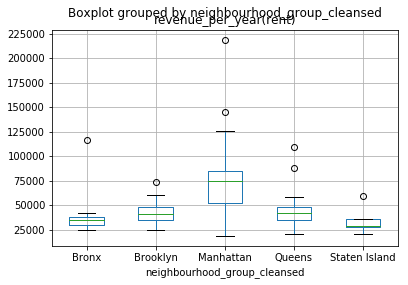

In [24]:
revenue_table.boxplot(by='neighbourhood_group_cleansed',column=revenue_table.columns[1])
plt.show()

From the box plot above Manhattan has the highest revenues followed by Brooklyn, Queens, Bronx and Staten Island. Also Mahnattan has more outliers in the sense that there are few costly/big hotels in Manhattan.

In [25]:
warnings.filterwarnings('ignore')
from bokeh.io import curdoc,show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.models import CategoricalColorMapper
from bokeh.layouts import column,row,widgetbox

mapper = CategoricalColorMapper(
factors=['Manhattan', 'Brooklyn',
'Queens','Staten Island','Bronx'],
palette=['red', 'green', 'blue','yellow','orange'])

# Make the ColumnDataSource: source
source = ColumnDataSource(data={
    'x'       : airbnb_final['zipcode'],
    'y'       : round(pd.to_numeric(airbnb_final.loc[:,'revenue_per_year(rent)']),0),
    'num'      : airbnb_final['number_of_listings'],
    'region'      : airbnb_final['neighbourhood_group_cleansed']
})


# Create the figure: plot
plot = figure(title='Revenue by zipcode (hover on the points to see information)', plot_height=400, plot_width=700,tools='box_select, lasso_select')

# Add circle glyphs to the plot
plot.circle(x='x', y='y', fill_alpha=0.8, source=source,color={'field': 'region','transform': mapper},legend='region')

# Set the x-axis label
plot.xaxis.axis_label ='Zipcodes in Newyork'

# Set the y-axis label
plot.yaxis.axis_label = 'Revenue_per_year(rent)'

from bokeh.models import HoverTool

hover = HoverTool(tooltips=[('Zipcode','@x'),('Revenue','@y'),('Region','@region'),('Listings','@num')])
plot.add_tools(hover)

# Add the plot to the current document and add a title
curdoc().add_root(plot)
curdoc().title = 'Revenue by zipcode'

show(plot)

Hovering on the points in the plot above you can see the information for various zipcodes as shown below
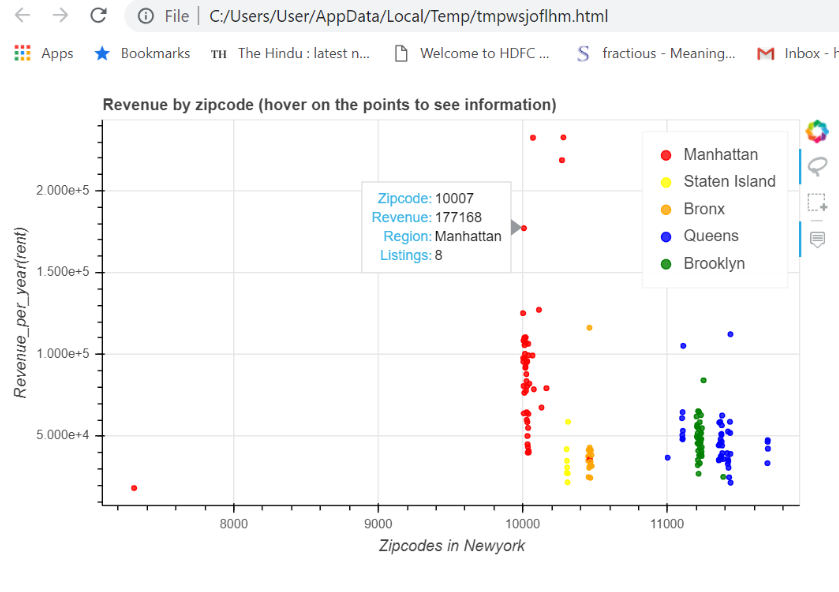

We have calculated the median revenues from each zipcodes using the Airbnb data now we will estimate the median price of the properties for each zipcode using the Zillow house price information so that we can calculate the ROI and payback_period required for making the investment decision.

# Property Values Estimation using Zillow data

In [26]:
zillow_data = pd.read_csv("Zhvi_2bedroom.csv", low_memory = False)

# Let us look at the data
print(zillow_data.shape)
print(zillow_data.head())

(8946, 262)
   RegionID  RegionName      City State     Metro CountyName  SizeRank  \
0     61639       10025  New York    NY  New York   New York         1   
1     84654       60657   Chicago    IL   Chicago       Cook         2   
2     61637       10023  New York    NY  New York   New York         3   
3     84616       60614   Chicago    IL   Chicago       Cook         4   
4     93144       79936   El Paso    TX   El Paso    El Paso         5   

    1996-04   1996-05   1996-06   ...     2016-09  2016-10  2016-11  \
0       NaN       NaN       NaN   ...     1374400  1364100  1366300   
1  167700.0  166400.0  166700.0   ...      368600   370200   372300   
2       NaN       NaN       NaN   ...     1993500  1980700  1960900   
3  195800.0  193500.0  192600.0   ...      398900   401200   403200   
4   59100.0   60500.0   60900.0   ...       82400    82300    82400   

     2016-12  2017-01  2017-02  2017-03  2017-04  2017-05  2017-06  
0  1354800.0  1327500  1317300  1333700  135210

We have 8946 rows and many rows are having data for cities other than New York.So we will filter out the data to include only New York City properties

In [27]:
# We need to get all the new york city data
zillow_nyc_data = zillow_data[zillow_data['City']=='New York']
print(zillow_nyc_data.head())
print(zillow_nyc_data.shape)

    RegionID  RegionName      City State     Metro CountyName  SizeRank  \
0      61639       10025  New York    NY  New York   New York         1   
2      61637       10023  New York    NY  New York   New York         3   
13     61703       10128  New York    NY  New York   New York        14   
14     61625       10011  New York    NY  New York   New York        15   
20     61617       10003  New York    NY  New York   New York        21   

    1996-04  1996-05  1996-06   ...     2016-09  2016-10  2016-11    2016-12  \
0       NaN      NaN      NaN   ...     1374400  1364100  1366300  1354800.0   
2       NaN      NaN      NaN   ...     1993500  1980700  1960900  1951300.0   
13      NaN      NaN      NaN   ...     1526000  1523700  1527200  1541600.0   
14      NaN      NaN      NaN   ...     2354000  2355500  2352200  2332100.0   
20      NaN      NaN      NaN   ...     1932800  1930400  1937500  1935100.0   

    2017-01  2017-02  2017-03  2017-04  2017-05  2017-06  
0   13275

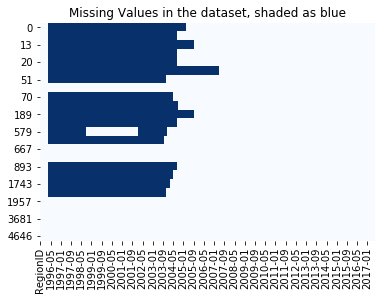

In [28]:
# We only have 25 zipcodes and we have the data till June 2017.Let us look at the missing values
plt.title("Missing Values in the dataset, shaded as blue")
sns.heatmap(zillow_nyc_data.isnull(), cbar=False, cmap = "Blues")
plt.show()

From the above graphs we can tell that the most of the data before 2007 is missing.

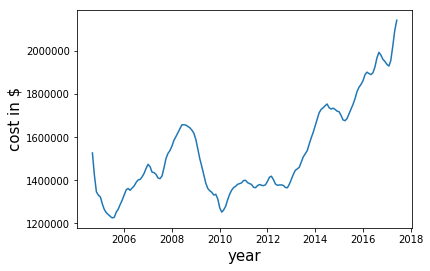

In [29]:
Region_1 = pd.concat((zillow_nyc_data.iloc[:,1],zillow_nyc_data.iloc[:,zillow_nyc_data.columns.get_loc('1996-04'):]),axis = 1)
zillow_Transpose = Region_1.set_index('RegionName').T.reset_index()
zillow_Transpose.set_index('index', inplace=True)
zillow_Transpose.index = pd.to_datetime(zillow_Transpose.index)
plt.plot(zillow_Transpose.index,np.array(zillow_Transpose.iloc[:,1]))
plt.xlabel('year',fontsize = 15)
plt.ylabel('cost in $',fontsize = 15)
plt.show()

From the above graphs we can tell that the prices are having an upward in general. However,the prices have fallen significantly after 2008 and this is due to financial crisis which happened mainly because of housing bubble.

So these kinds of events are very less often and by including them in our model might lead to poor forecasting also most of the data is missing before the 2007 period.

Hence,we will consider the data from 2010-01 which give a better forecast and since the data is monthly,8 years of data would be a good input for our model and we wont be compromising on the data

In [30]:
# Selecting the columns from '2010-01'
zillow_new = pd.concat((zillow_nyc_data.iloc[:,1],zillow_nyc_data.iloc[:,zillow_nyc_data.columns.get_loc('2010-01'):]),axis = 1)
print(zillow_new.head())

    RegionName    2010-01    2010-02    2010-03    2010-04    2010-05  \
0        10025   813300.0   821500.0   831700.0   845100.0   854500.0   
2        10023  1271900.0  1252300.0  1262300.0  1279200.0  1309000.0   
13       10128   985400.0   983700.0   983400.0  1007600.0  1023000.0   
14       10011  1378600.0  1372300.0  1393100.0  1430000.0  1462100.0   
20       10003  1227800.0  1202600.0  1207100.0  1220100.0  1252400.0   

      2010-06    2010-07    2010-08    2010-09   ...     2016-09  2016-10  \
0    858900.0   859200.0   863500.0   876000.0   ...     1374400  1364100   
2   1335300.0  1353800.0  1366400.0  1372100.0   ...     1993500  1980700   
13  1010500.0  1006800.0  1019400.0  1026900.0   ...     1526000  1523700   
14  1476800.0  1479000.0  1476600.0  1461200.0   ...     2354000  2355500   
20  1285700.0  1278300.0  1279100.0  1326700.0   ...     1932800  1930400   

    2016-11    2016-12  2017-01  2017-02  2017-03  2017-04  2017-05  2017-06  
0   1366300  135480

Summary of house prices in 2017-06

In [31]:
zillow_new.iloc[:,-1].describe()

count    2.500000e+01
mean     1.289684e+06
std      8.825707e+05
min      3.277000e+05
25%      3.905000e+05
50%      1.302300e+06
75%      2.031600e+06
max      3.316500e+06
Name: 2017-06, dtype: float64

In [32]:
# First we need to transpose the elements and name the index in date-time format for time series
zillow_final = zillow_new.set_index('RegionName').T.reset_index()
zillow_final.index = pd.to_datetime(zillow_final.index)
zillow_final.set_index('index', inplace=True)
zillow_final.head()

RegionName,10025,10023,10128,10011,10003,11201,11234,10314,11215,10028,...,10312,10022,11217,10013,11231,10304,10305,10309,10308,10303
index,,,,,,,,,,,,,,,,,,,,,
2010-01,813300.0,1271900.0,985400.0,1378600.0,1227800.0,742800.0,378700.0,288700.0,529300.0,1126000.0,...,296200.0,1323000.0,619000.0,2268700.0,591300.0,266200.0,331100.0,320000.0,323400.0,267300.0
2010-02,821500.0,1252300.0,983700.0,1372300.0,1202600.0,747500.0,386600.0,290800.0,544800.0,1107300.0,...,296400.0,1338500.0,619300.0,2294100.0,589600.0,266100.0,330000.0,320000.0,324900.0,269300.0
2010-03,831700.0,1262300.0,983400.0,1393100.0,1207100.0,750300.0,391600.0,290200.0,540900.0,1116100.0,...,296900.0,1344600.0,612700.0,2273600.0,589500.0,264700.0,328100.0,317400.0,325000.0,265700.0
2010-04,845100.0,1279200.0,1007600.0,1430000.0,1220100.0,753800.0,392900.0,289200.0,538300.0,1138500.0,...,296700.0,1348300.0,612800.0,2261700.0,589300.0,262500.0,327200.0,314900.0,326000.0,262900.0
2010-05,854500.0,1309000.0,1023000.0,1462100.0,1252400.0,758900.0,392900.0,287000.0,536800.0,1175900.0,...,295100.0,1350800.0,614500.0,2282800.0,590900.0,260800.0,324500.0,313100.0,324700.0,260900.0


Plotting the property values across time period

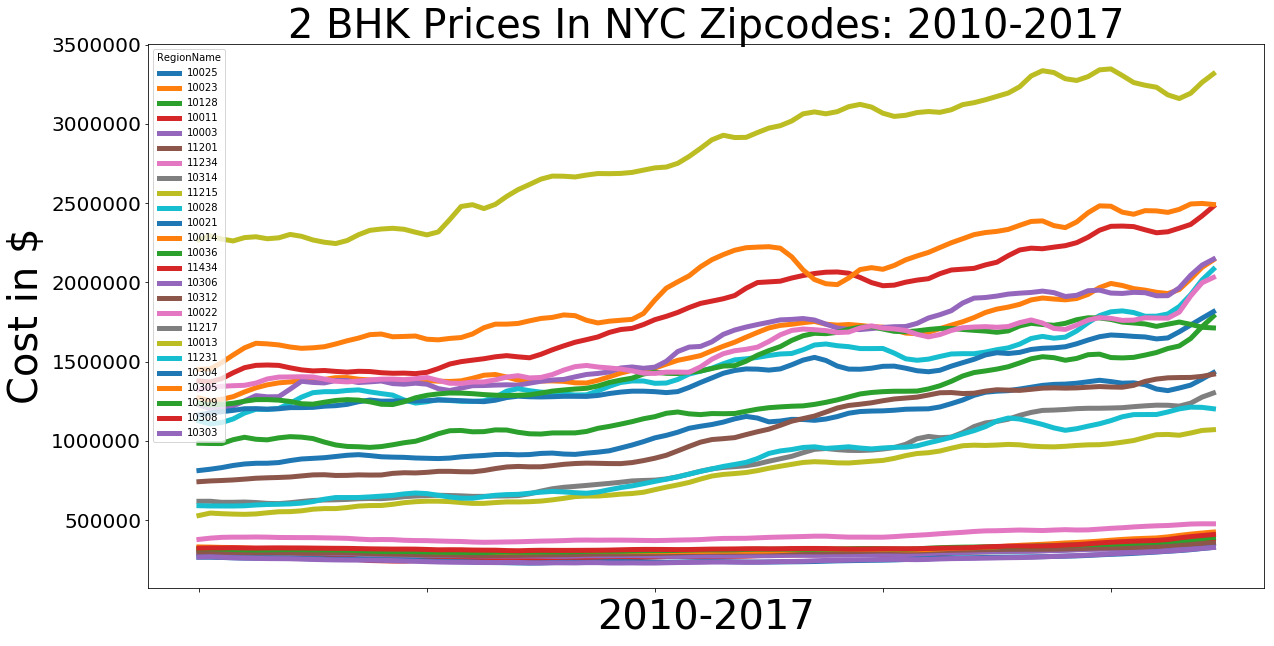

In [33]:
zillow_final.iloc[:,:].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("2 BHK Prices In NYC Zipcodes: 2010-2017", fontsize = 40)
plt.xlabel('2010-2017', fontsize=40)
plt.ylabel('Cost in $', fontsize = 40)
plt.show();

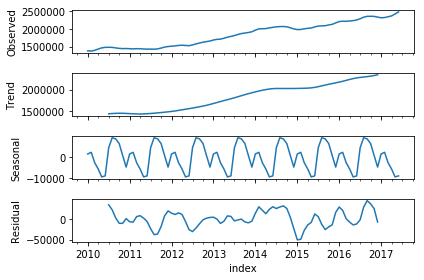

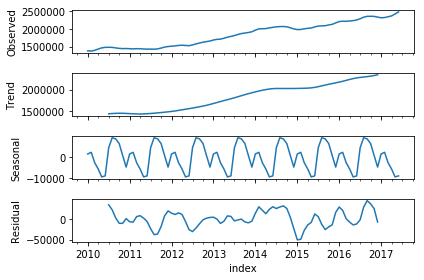

In [34]:
zillow_1 = zillow_final.loc[:,10011]
from statsmodels.tsa.seasonal import seasonal_decompose
zillow_1.index = pd.to_datetime(zillow_1.index)
output= seasonal_decompose(zillow_1)
output.plot()


From the first look of seasonal decompose plot we can find the presence of seasonal component and an overall upward trend.
It make sense to use a Seasonal ARIMA model. Also the number of observations per seasonal cycle here m=12

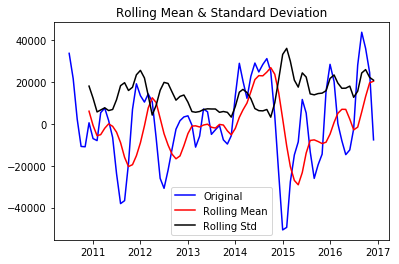

Results of Dickey-Fuller Test:
Test Statistic                 -3.593124
p-value                         0.005894
#Lags Used                      8.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [35]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(6,center=False).mean()
    rolstd = timeseries.rolling(6,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(output.resid.dropna())

From the above plot we can see that the property price data after removing trend and seasonality is fairly stationary which is also confirmed by the dicker fuller test. The P value is less than 0.05. Also, here the test statistic(-3.593124) is smaller than the 1% critical value (-3.528890). So we can model the data using ARIMA model.

In [36]:
from pmdarima.arima import auto_arima

stepwise_model = auto_arima(zillow_1, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True, disp = 0)

train = zillow_1.loc['2010-01':'2016-06']
test = zillow_1.loc['2016-07':]
stepwise_model.fit(train)

print(stepwise_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   78
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -746.964
Date:                            Wed, 29 May 2019   AIC                           1501.928
Time:                                    22:28:15   BIC                           1510.626
Sample:                                         0   HQIC                          1505.360
                                             - 78                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2084.6153   2675.353      0.779      0.436   -3158.980    7328.210
ar.S.L12       0.4288      0.373   

We can see that Auto-arima function in 'pmdarima' package using a grid search gave the optimal parameters required for the seasonal arima model (i.e.(p,q,d) for Arima and (P,Q,D) for seasonal Arima models).

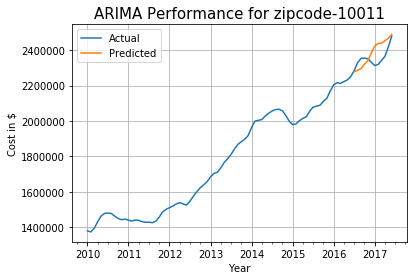

In [37]:
future_forecast = stepwise_model.predict(n_periods=12)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

pd.concat([zillow_1,future_forecast],axis=1).plot()
plt.grid()
L=plt.legend()
L.get_texts()[0].set_text('Actual')
L.get_texts()[1].set_text('Predicted')
plt.title("ARIMA Performance for zipcode-10011", fontsize = 15)
plt.ylabel("Cost in $", fontsize = 10)
plt.xlabel("Year", fontsize = 10)
plt.show()

Our Prediction was pretty decent and I feel ARIMA is doing a good job in forecasting the prices.
So now we will train the model for all the zipcodes and predict prices for 2020-01.
I am considering 2020-01 for my analysis as the company is looking for buying properties and 
I am assuming that the company is going to purchase the property in Jan-2020

In [38]:
zillow_costs = [] #Empty list to which we shall append resulting price values for each zipcode
for zipcode in zillow_final.columns:
    data = zillow_final.loc[:,[zipcode]]
    data.index = pd.to_datetime(data.index)
    stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    stepwise_model.fit(data)
    price_forecast = stepwise_model.predict(n_periods=30)[-1]    
    zillow_costs.append(price_forecast)

In [39]:
# Now we will merge the costs and get the predicted cost of properties in these zip codes
pd.Series(zillow_costs)
zillow_final = round(pd.DataFrame({'zipcode': zillow_nyc_data['RegionName'].tolist(),'Predicted_cost':zillow_costs,'last_known_cost':zillow_nyc_data.iloc[:,-1]}))
print(zillow_final.head())

    zipcode  Predicted_cost  last_known_cost
0     10025       1540722.0          1431000
2     10023       2764842.0          2142300
13    10128       2536381.0          1787100
14    10011       3117724.0          2480400
20    10003       2604304.0          2147000


# Scalable function for property value estimation

In [40]:
def forecast(data,city,start_date = '2010-01'):
    data_city = data[data['City']==city]
    data_1 = pd.concat((data_city.iloc[:,1],data_city.iloc[:,data_city.columns.get_loc(start_date):]),axis = 1)
    data_2 = data_1.set_index("RegionName").T.reset_index()
    data_2.index = pd.to_datetime(data_2.index)
    data_2.set_index('index', inplace=True)
    costs = []
    for zipcode in data_2.columns:
        data = data_2.loc[:,[zipcode]]
        data.index = pd.to_datetime(data.index)
        stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
        stepwise_model.fit(data)
        price_forecast = stepwise_model.predict(n_periods=30)[-1]    
        costs.append(price_forecast)    
    data_2 = pd.DataFrame({'zipcode': data_1['RegionName'].tolist(),'Predicted_cost':costs,'last_known_cost':data_1.iloc[:,-1]})
    return data_2
forecasted = round(forecast(zillow_data,'New York'),)
print(forecasted.head())

    zipcode  Predicted_cost  last_known_cost
0     10025       1540722.0          1431000
2     10023       2764842.0          2142300
13    10128       2536381.0          1787100
14    10011       3117724.0          2480400
20    10003       2604304.0          2147000


In [41]:
#Now we will merge our zillow table with the revenue table to calculate the profit and breakeven period
df_final = pd.merge(round(revenue_table),forecasted,on = 'zipcode',how = 'inner')
df_final.zipcode = [math.trunc(x) for x in df_final.zipcode]
df_final.rename(columns={'neighbourhood_group_cleansed':'neighbourhood'}, inplace=True)
df_final.head()

,zipcode,revenue_per_year(rent),revenue_per_year(guests),revenue_per_year(cleaning),revenue_per_year(rent+cleaning),neighbourhood,number_of_listings,Predicted_cost,last_known_cost
0,10036,90132.0,1642.0,7660.0,99303.0,Manhattan,112,1611214.0,1712900
1,10013,89242.0,0.0,8212.0,96360.0,Manhattan,83,3441917.0,3316500
2,10011,87395.0,0.0,8212.0,95333.0,Manhattan,104,3117724.0,2480400
3,10022,82125.0,821.0,8212.0,91980.0,Manhattan,38,2851821.0,2031600
4,10014,84178.0,0.0,8158.0,90310.0,Manhattan,98,2624550.0,2491600


In [42]:
def Profitability(revenues,home_prices,criteria = 0):
    df = pd.merge(revenues,home_prices,on = 'zipcode',how = 'inner')
    df.zipcode = [math.trunc(x) for x in df_final.zipcode]
    df.rename(columns={'neighbourhood_group_cleansed':'neighbourhood'}, inplace=True)
    df['%increase']=(df['Predicted_cost']-df['last_known_cost'])/df['last_known_cost']
    df['revenue_per_year_adj(guests)']=df['revenue_per_year(guests)']*(1+df['%increase'])
    df['revenue_per_year_adj(cleaning)']=df['revenue_per_year(cleaning)']*(1+df['%increase'])
    df['revenue_per_year_adj(rent)']=df['revenue_per_year(rent)']*(1+df['%increase'])
    df['revenue_per_year_adj(rent+cleaning)']=df['revenue_per_year(rent+cleaning)']*(1+df['%increase'])
    df['ROI(rent)%'] = (df['revenue_per_year_adj(rent)']/df_final['Predicted_cost'])*100
    df['ROI(rent+cleaning)%'] = (df['revenue_per_year_adj(rent+cleaning)']/df_final['Predicted_cost'])*100
    df['Payback_period(years)'] = (df['Predicted_cost']/df['revenue_per_year_adj(rent)'])
    df =df.sort_values('ROI(rent)%',ascending = False)
    out =df[df['number_of_listings'] > criteria]
    return round(out,2)

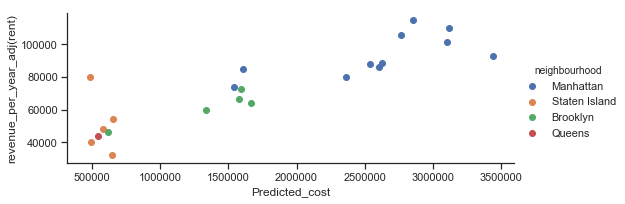

In [43]:
profit_table_1 = Profitability(revenue_table,forecasted,0)
sns.set(style = 'ticks')
plot = sns.FacetGrid(data = profit_table_1,hue = 'neighbourhood',hue_order = ['Manhattan','Staten Island','Brooklyn','Queens'],aspect = 2.5)
plot.map(plt.scatter,'Predicted_cost','revenue_per_year_adj(rent)').add_legend()
plt.show()

In [44]:
profit_table_1

,zipcode,revenue_per_year(rent),revenue_per_year(guests),revenue_per_year(cleaning),revenue_per_year(rent+cleaning),neighbourhood,number_of_listings,Predicted_cost,last_known_cost,%increase,revenue_per_year_adj(guests),revenue_per_year_adj(cleaning),revenue_per_year_adj(rent),revenue_per_year_adj(rent+cleaning),ROI(rent)%,ROI(rent+cleaning)%,Payback_period(years)
11,10312,58856.25,0.00,3142.19,61998.44,Staten Island,1,484353.0,355000,0.36,0.00,4287.13,80301.98,84589.10,16.58,17.46,6.03
20,10304,27169.69,615.94,1642.51,28812.20,Staten Island,2,584228.0,328300,0.78,1096.09,2922.94,48349.96,51272.90,8.28,8.78,12.08
16,10305,35040.00,3285.00,4458.21,40788.75,Staten Island,9,653962.0,425100,0.54,5053.55,6858.39,53904.56,62748.28,8.24,9.60,12.13
18,10306,28743.75,3285.00,5338.12,34081.88,Staten Island,2,492504.0,352900,0.40,4584.52,7449.84,40114.51,47564.35,8.15,9.66,12.28
19,11434,30660.00,1642.50,2326.88,33534.38,Queens,9,545999.0,382300,0.43,2345.81,3323.23,43788.46,47893.63,8.02,8.77,12.47
17,11234,35929.69,6364.69,3490.32,37401.10,Brooklyn,6,617431.0,476900,0.29,8240.21,4518.84,46517.31,48422.31,7.53,7.84,13.27
0,10036,90132.19,1642.50,7659.52,99302.81,Manhattan,112,1611214.0,1712900,-0.06,1544.99,7204.82,84781.51,93407.72,5.26,5.80,19.00
21,10308,20257.50,2463.75,2053.12,22310.62,Staten Island,1,647603.0,409500,0.58,3896.29,3246.91,32036.19,35283.10,4.95,5.45,20.21
7,10025,68437.50,0.00,7008.00,76650.00,Manhattan,112,1540722.0,1431000,0.08,0.00,7545.34,73684.95,82527.14,4.78,5.36,20.91
13,11231,54750.00,0.00,7801.88,60977.81,Brooklyn,74,1595566.0,1202900,0.33,0.00,10348.66,72622.20,80882.97,4.55,5.07,21.97


From the graphs above we can infer that Manhattan has high cost and revenues followed by Brooklyn and Statan island.
However, we not have enough data data to comment in general as we have only information of 25 properties.
But we are interested in in properties with less cost and more revenue i.e high ROI and less Payback_period (plots shown below)

Text(0, 0.5, 'ROI(rent)%')

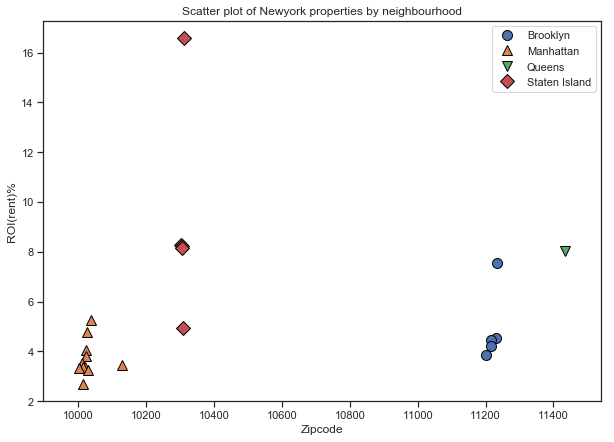

In [45]:
import mglearn
plt.figure(figsize=(10, 7))
mglearn.discrete_scatter(profit_table_1['zipcode'],profit_table_1['ROI(rent)%'],profit_table_1['neighbourhood'],ax=None)
plt.title("Scatter plot of Newyork properties by neighbourhood")
plt.legend(np.sort(profit_table_1['neighbourhood'].unique()))
plt.xlabel("Zipcode")
plt.ylabel("ROI(rent)%")

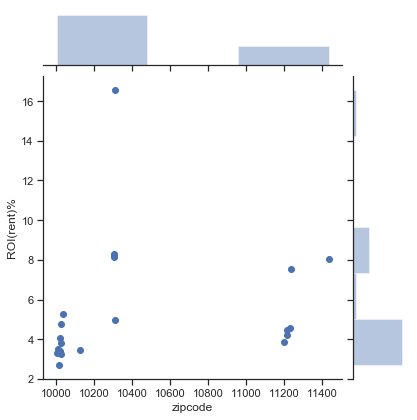

In [46]:
sns.jointplot(x = 'zipcode', y ='ROI(rent)%',data=profit_table_1,color='b')
plt.show()


Most of the properties have ROI of ~3-10% and most of the properties are concentrated around the zipcodes (10000-10300)

# Median Profit by region

In [47]:
profit_table_region = profit_table_1.groupby(['neighbourhood'], as_index=False).median()[['neighbourhood', 
                                                                 'revenue_per_year_adj(rent)','revenue_per_year_adj(cleaning)',
                                                         'revenue_per_year_adj(rent+cleaning)','Predicted_cost','number_of_listings']]

profit_table_region['ROI(rent)%'] = (profit_table_region['revenue_per_year_adj(rent)']/profit_table_region['Predicted_cost'])*100
profit_table_region['ROI(rent+cleaning)%'] = (profit_table_region['revenue_per_year_adj(rent+cleaning)']/profit_table_region['Predicted_cost'])*100
profit_table_region['Payback_period(years)'] = (profit_table_region['Predicted_cost']/profit_table_region['revenue_per_year_adj(rent)'])
round(profit_table_region.sort_values('ROI(rent)%'))


,neighbourhood,revenue_per_year_adj(rent),revenue_per_year_adj(cleaning),revenue_per_year_adj(rent+cleaning),Predicted_cost,number_of_listings,ROI(rent)%,ROI(rent+cleaning)%,Payback_period(years)
1,Manhattan,88670.0,8593.0,96131.0,2624550.0,83,3.0,4.0,30.0
0,Brooklyn,64234.0,8766.0,70657.0,1579686.0,74,4.0,4.0,25.0
2,Queens,43788.0,3323.0,47894.0,545999.0,9,8.0,9.0,12.0
3,Staten Island,48350.0,4287.0,51273.0,584228.0,2,8.0,9.0,12.0


In general, Staten Island and Queens has higher ROI and lower Payback_period making it more preferable to invest 

But Manhattan and Brooklyn have more properties giving more options for the investor

Also, we have to look into specific pincodes and number of listings in the area so that we have more options to make investment

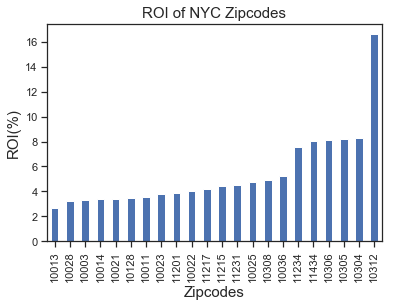

,zipcode,revenue_per_year(rent),revenue_per_year(guests),revenue_per_year(cleaning),revenue_per_year(rent+cleaning),neighbourhood,number_of_listings,Predicted_cost,last_known_cost,%increase,revenue_per_year_adj(guests),revenue_per_year_adj(cleaning),revenue_per_year_adj(rent),revenue_per_year_adj(rent+cleaning),ROI(rent)%,ROI(rent+cleaning)%,Payback_period(years)
11,10312,58856.25,0.00,3142.19,61998.44,Staten Island,1,484353.0,355000,0.36,0.00,4287.13,80301.98,84589.10,16.58,17.46,6.03
20,10304,27169.69,615.94,1642.51,28812.20,Staten Island,2,584228.0,328300,0.78,1096.09,2922.94,48349.96,51272.90,8.28,8.78,12.08
16,10305,35040.00,3285.00,4458.21,40788.75,Staten Island,9,653962.0,425100,0.54,5053.55,6858.39,53904.56,62748.28,8.24,9.60,12.13
18,10306,28743.75,3285.00,5338.12,34081.88,Staten Island,2,492504.0,352900,0.40,4584.52,7449.84,40114.51,47564.35,8.15,9.66,12.28
19,11434,30660.00,1642.50,2326.88,33534.38,Queens,9,545999.0,382300,0.43,2345.81,3323.23,43788.46,47893.63,8.02,8.77,12.47


In [48]:
###### pairplot ######
#sns.pairplot(profit_table_1,hue='neighbourhood')

profit_table_1.sort_values('ROI(rent)%',ascending = True).plot(x = 'zipcode', y = 'ROI(rent)%', kind = "bar", legend = False,color='b')
plt.title("ROI of NYC Zipcodes", fontsize = 15)
plt.ylabel("ROI(%)", fontsize = 15)
plt.xlabel("Zipcodes", fontsize = 15)
plt.show()
profit_table_1.head()

# Preliminary results

From our preliminary analysis above we can see that cheaper properties are in Staten Island and Queens.
But Manhattan has costly properties with high revenues and more properties listed.

Overall we can tell that 10312,10304,10305,10306,11434 are the top lucrative Zip codes to invest in. 4 from Staten Island and 1 from Queens

Most of the pincodes are near by which generally make sense because properties in same locality tend to behave similarly.

10312,10304,10306 have only 1 or 2 listing. It is better to invest in zipcodes 10305(Staten Island) or 11434 (Queens) having 9 listings giving the client with very more options to invest in.


# Conditioning on the minimum number of listing in the zipcode

In [49]:
profit_table_10listings = Profitability(revenue_table,forecasted,10)
profit_table_10listings.head()

,zipcode,revenue_per_year(rent),revenue_per_year(guests),revenue_per_year(cleaning),revenue_per_year(rent+cleaning),neighbourhood,number_of_listings,Predicted_cost,last_known_cost,%increase,revenue_per_year_adj(guests),revenue_per_year_adj(cleaning),revenue_per_year_adj(rent),revenue_per_year_adj(rent+cleaning),ROI(rent)%,ROI(rent+cleaning)%,Payback_period(years)
0,10036,90132.19,1642.5,7659.52,99302.81,Manhattan,112,1611214.0,1712900,-0.06,1544.99,7204.82,84781.51,93407.72,5.26,5.80,19.00
7,10025,68437.50,0.0,7008.00,76650.00,Manhattan,112,1540722.0,1431000,0.08,0.00,7545.34,73684.95,82527.14,4.78,5.36,20.91
13,11231,54750.00,0.0,7801.88,60977.81,Brooklyn,74,1595566.0,1202900,0.33,0.00,10348.66,72622.20,80882.97,4.55,5.07,21.97
15,11215,47906.25,0.0,7035.37,53312.81,Brooklyn,144,1336799.0,1070800,0.25,0.00,8783.04,59806.71,66556.33,4.47,4.98,22.35
12,11217,54750.00,0.0,7227.00,61114.69,Brooklyn,86,1579686.0,1302300,0.21,0.00,8766.33,66411.59,74131.93,4.20,4.69,23.79


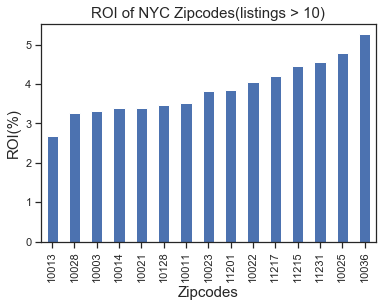

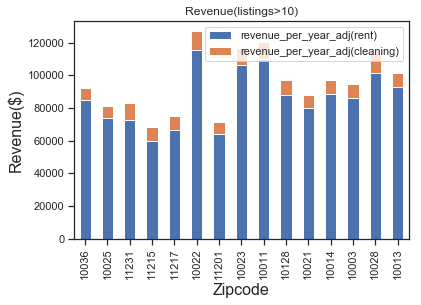

In [50]:
profit_table_10listings.sort_values('ROI(rent)%',ascending = True).plot(x = 'zipcode', y = 'ROI(rent)%', kind = "bar", legend = False,color='b')
plt.title("ROI of NYC Zipcodes(listings > 10)", fontsize = 15)
plt.ylabel("ROI(%)", fontsize = 15)
plt.xlabel("Zipcodes", fontsize = 15)
plt.show()

profit_table_10listings[['zipcode','revenue_per_year_adj(rent)','revenue_per_year_adj(cleaning)']].plot(x= 'zipcode',kind='bar',stacked = True,title='Revenue(listings>10)')
plt.xlabel('Zipcode',fontsize=16)
plt.ylabel('Revenue($)',fontsize=16)
plt.show()


# Conclusions / Key findings

From the client perspective, if they need more options to invest in a zip code then 10036,10025,11231 are lucrative zip codes with more than 70 listings under them.

One key observation is that zipcodes with highest ROI% are in Staten Island but they have very few listings and Manhattan has the most lucrative zip codes having more than 100 listings but with higher prices (~1.6M). 

I would recommend the company to invest in 10036 (Manhattan) as it is having good ROI and has more than 100 listings to choose from. It even has one of the highest revenues also considering that Manhattan being a high growth area the property value might increase more compared to other regions.

But 10312 outsmarts all other zip codes in the ROI(~17%), but it has only 1 listing. By collecting more information on this zipcode, the company can invest in 10312 as it is the best one in terms of profits. If the client has budget constraints, then Staten Island (10312,10304,10305,10306) is the best neighborhood to invest in as the properties are cheaper properties (price in the range of 500-600K) and have good return on investment.

Inclusion of cleaning fee might not significantly affect the order of lucrative zipcodes as it is forming a very small part(~11%) of our revenue also we are not sure if there are any chances for profit making though cleaning fee.

Here the functions to calculate revenues,forecast prices and calculate ROI are all scaleable. These functions can be used for future purpose when the client is trying to enter new market.

In [51]:
from bokeh.io import curdoc,show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.models import CategoricalColorMapper
from bokeh.layouts import column,row,widgetbox

mapper = CategoricalColorMapper(
factors=['Manhattan', 'Brooklyn',
'Queens','Staten Island'],
palette=['red', 'green', 'blue','orange'])

# Make the ColumnDataSource: source
source = ColumnDataSource(data={
    'x'       : profit_table_10listings['ROI(rent)%'],
    'y'       : profit_table_10listings['Payback_period(years)'],
    'num'      : profit_table_10listings['number_of_listings'],
    'region'      : profit_table_10listings['neighbourhood'],
    'Zipcode':profit_table_10listings['zipcode']
})

plot = figure(title='ROI vs.Payback_period by zipcode (hover on the points to see information)', plot_height=400, plot_width=700,tools='box_select, lasso_select')

# Add circle glyphs to the plot
plot.circle(x='x', y='y', fill_alpha=0.8, source=source,color={'field': 'region','transform': mapper},legend='region')

# Set the x-axis label
plot.xaxis.axis_label ='ROI(%)'

# Set the y-axis label
plot.yaxis.axis_label = 'Payback_period(years)'

from bokeh.models import HoverTool

hover = HoverTool(tooltips=[('Zipcode','@Zipcode'),('ROI(%)','@x'),('Payback(years)','@y'),('Region','@region'),('Listings','@num')])
plot.add_tools(hover)

# Add the plot to the current document and add a title
curdoc().add_root(plot)
curdoc().title = 'ROI vs Payback_period(years) by zipcode (with >10 listings)'
show(plot)

Interactive plot to find the zipcode with best ROI and number of listings >10:
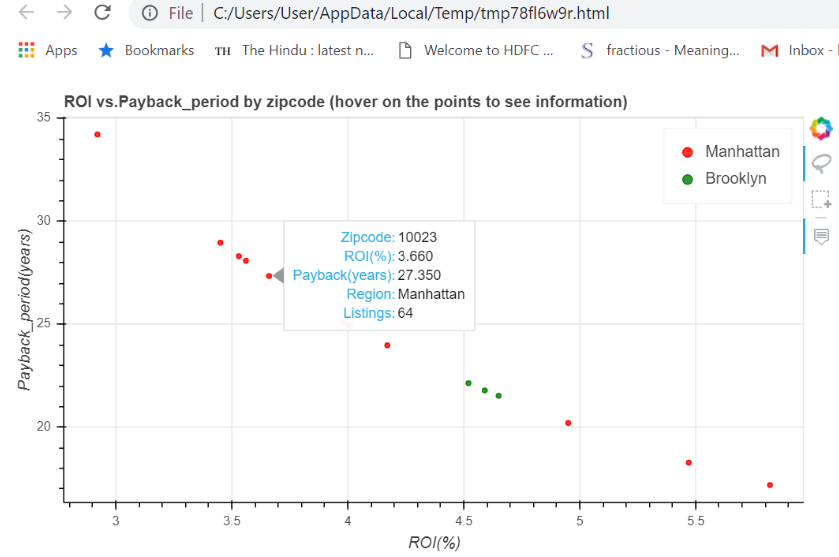